# Perform decoding and encoding
Decode ROI and continuous images into text and encode text into continuous image.

In [1]:
%matplotlib inline
from os.path import join

import nibabel as nib
from nilearn import plotting
from nltools.mask import create_sphere

from gclda.model import Model
from gclda.decode import Decoder
from gclda.utils import get_resource_path

/Users/tsalo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
%%time
# Load example model and initialize decoder
model = Model.load(join(get_resource_path(), 'models',
                        'Neurosynth2015Filtered2',
                        'model_200topics_2015Filtered2.pkl'))
decoder = Decoder(model)

model.display_model_summary()

--- Model Summary ---
 Current State:
	 Current Iteration   = 1000
	 Initialization Seed = 1
	 Current Log-Likely  = -10981413.4523
 Model Hyper-Parameters:
	 Symmetric = 0.1
	 n_topics  = 200
	 n_regions = 2
	 alpha     = 0.010
	 beta      = 0.010
	 gamma     = 1.000
	 delta     = 25.000
	 roi_size  = 1.000
	 dobs      = 50
 Model Training-Data Information:
	 Dataset Label                 = 2015Filtered2
	 Word-Tokens (n_word_tokens)   = 520492
	 Peak-Tokens (n_peak_tokens)   = 400801
	 Word-Types (n_word_labels)    = 6755
	 Documents (n_docs)            = 11362
	 Peak-Dimensions (n_peak_dims) = 3
CPU times: user 6.16 s, sys: 881 ms, total: 7.05 s
Wall time: 7.25 s


## Decode a region of interest
### From a file

              Weight
Term                
face        0.058136
words       0.037848
faces       0.033243
perceptual  0.032793
category    0.031667
repetition  0.025886
word        0.022321
repeated    0.018054
priming     0.017504
categories  0.015661
CPU times: user 11.2 s, sys: 7.1 s, total: 18.2 s
Wall time: 14.1 s


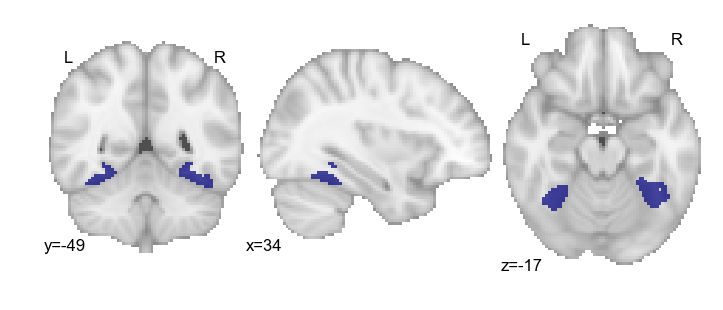

In [3]:
%%time
roi_file = 'data/fusiform.nii.gz'
fusiform_df, _ = decoder.decode_roi(roi_file)
fusiform_df = fusiform_df.sort_values(by='Weight', ascending=False)
print(fusiform_df.head(10))

roi_img = nib.load(roi_file)
fig = plotting.plot_roi(roi_img, display_mode='ortho',
                        draw_cross=False)

### From a set of coordinates

/Users/tsalo/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


              Weight
Term                
words       0.092615
face        0.082551
word        0.053966
faces       0.045733
letters     0.026157
perceptual  0.023177
category    0.020456
letter      0.020230
chinese     0.016646
reading     0.016640
CPU times: user 11.5 s, sys: 7.04 s, total: 18.5 s
Wall time: 14.8 s


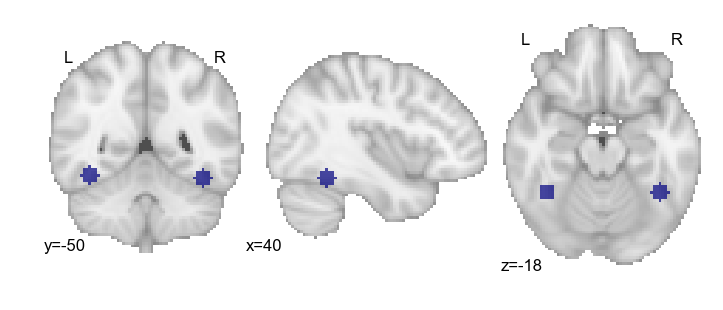

In [4]:
%%time
# Peak coordinates from Neurosynth fusiform meta-analysis.
coords = [[-40, -50, -16],
          [40, -50, -18]]
radii = [6] * len(coords)

# Create mask image
mask_data = (model.dataset.masker.volume.get_data()!=0).astype(int)
affine = model.dataset.masker.volume.affine
mask = nib.Nifti1Image(mask_data, affine)

roi_img = create_sphere(coords, radius=radii, mask=mask)
fusiform_df, _ = decoder.decode_roi(roi_img)
fusiform_df = fusiform_df.sort_values(by='Weight', ascending=False)
print(fusiform_df.head(10))

fig = plotting.plot_roi(roi_img, display_mode='ortho',
                        draw_cross=False)

## Decode a continuous image
For some reason, the seemingly relevant features actually have the lowest weights, which is why `ascending` is currently set to `True`. We need to look into why this is happening. Also, when we decode `pFgA`, `pAgF`, `pFgA_given_pF=0.50`, or `pAgF_given_pF=0.50` images, we don't even get that pattern.

              Weight
Term                
motor       0.017074
visual      0.016164
face        0.016045
faces       0.012292
memory      0.009784
emotional   0.008955
encoding    0.006252
words       0.005920
perceptual  0.005742
emotion     0.004486
CPU times: user 11.3 s, sys: 7.75 s, total: 19 s
Wall time: 13.8 s


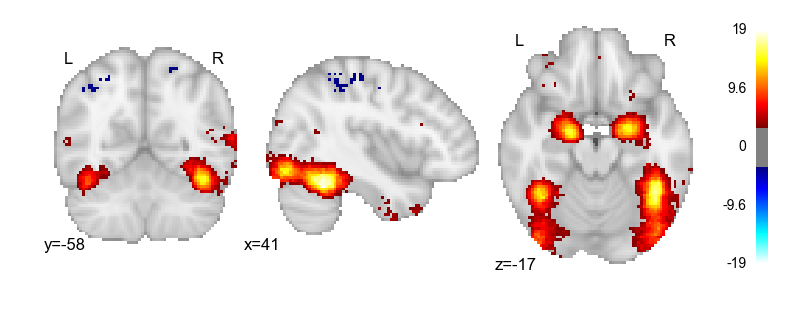

In [5]:
%%time
continuous_file = 'data/faces_specificity_z.nii.gz'
faces_df, _ = decoder.decode_continuous(continuous_file)
faces_df = faces_df.sort_values(by='Weight', ascending=False)
print(faces_df.head(10))

continuous_img = nib.load(continuous_file)
fig = plotting.plot_stat_map(continuous_img, display_mode='ortho', 
                             threshold=3.3, draw_cross=False)

## Encode text into an image

In [6]:
# From https://www.ncbi.nlm.nih.gov/pubmed/26093327
abstract = ('We present a novel strategy for deriving a '
            'classification system of functional neuroimaging '
            'paradigms that relies on hierarchical clustering '
            'of experiments archived in the BrainMap database. '
            'The goal of our proof-of-concept application was '
            'to examine the underlying neural architecture of '
            'the face perception literature from a meta-analytic '
            'perspective, as these studies include a wide range '
            'of tasks. Task-based results exhibiting similar '
            'activation patterns were grouped as similar, while '
            'tasks activating different brain networks were '
            'classified as functionally distinct. We identified '
            'four sub-classes of face tasks: (1) Visuospatial '
            'Attention and Visuomotor Coordination to Faces, '
            '(2) Perception and Recognition of Faces, (3) Social '
            'Processing and Episodic Recall of Faces, and (4) '
            'Face Naming and Lexical Retrieval. Interpretation '
            'of these sub-classes supports an extension of a well-'
            'known model of face perception to include a core '
            'system for visual analysis and extended systems for '
            'personal information, emotion, and salience '
            'processing. Overall, these results demonstrate that '
            'a large-scale data mining approach can inform the '
            'evolution of theoretical cognitive models by probing '
            'the range of behavioral manipulations across '
            'experimental tasks.')

CPU times: user 11.2 s, sys: 8.79 s, total: 20 s
Wall time: 15.5 s


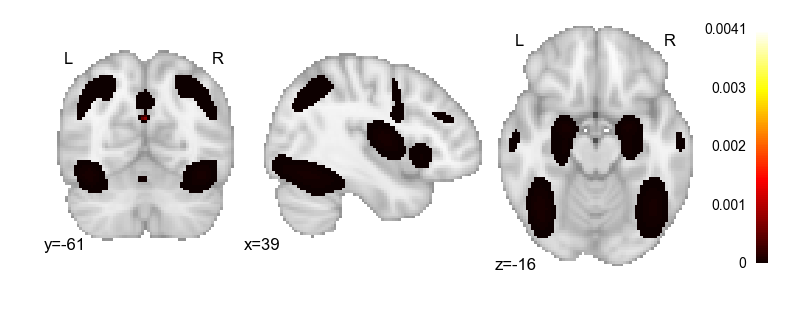

In [7]:
%%time
encoded_img, _ = decoder.encode(abstract)
fig = plotting.plot_stat_map(encoded_img, display_mode='ortho', 
                             threshold=.00001, draw_cross=False)

## Topic Seeding
You can "seed" priors for a decoding or encoding analysis with an input image or text.
All you have to do is pass the image or text through the appropriate decoding/encoding function and use the topic weights returned from that initial pass as the prior for decoding or encoding the image or text of interest.

Here we decode the faces meta-analysis after deriving topic priors from the anatomical fusiform ROI.

              Weight
Term                
face        0.107028
faces       0.058122
words       0.048469
perceptual  0.036929
category    0.035749
word        0.028140
repetition  0.026953
repeated    0.018798
priming     0.018125
categories  0.017723
CPU times: user 21.6 s, sys: 28.6 s, total: 50.3 s
Wall time: 35.4 s


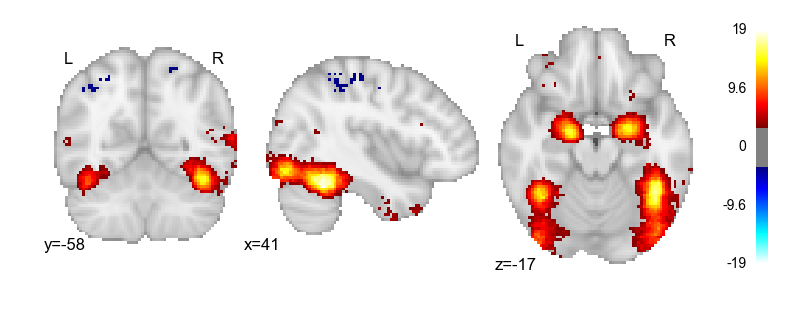

In [8]:
%%time
# Get the updated priors
roi_file = 'data/fusiform.nii.gz'
_, fusiform_probs = decoder.decode_roi(roi_file)

# Decode the image of interest
continuous_file = 'data/faces_specificity_z.nii.gz'
faces_df, _ = decoder.decode_continuous(continuous_file,
                                        topic_priors=fusiform_probs)
faces_df = faces_df.sort_values(by='Weight', ascending=False)
print(faces_df.head(10))

continuous_img = nib.load(continuous_file)
fig = plotting.plot_stat_map(continuous_img, display_mode='ortho', 
                             threshold=3.3, draw_cross=False)